Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [10]:
url = 'http://commondatastorage.googleapis.com/books1000/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [11]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [12]:
from IPython.core.display import Image, display


for folder in test_folders:
    files = os.listdir(folder)
    print(os.path.join(folder,(files[0])))
    img = Image(os.path.join(folder,(files[0])))
    display(img)

notMNIST_small/A/MDEtMDEtMDAudHRm.png


notMNIST_small/B/MDEtMDEtMDAudHRm.png


notMNIST_small/C/MDEtMDEtMDAudHRm.png


notMNIST_small/D/MDEtMDEtMDAudHRm.png


notMNIST_small/E/MDEtMDEtMDAudHRm.png


notMNIST_small/F/MDEtMDEtMDAudHRm.png


notMNIST_small/G/MDEtMDEtMDAudHRm.png


notMNIST_small/H/MDEtMDEtMDAudHRm.png


notMNIST_small/I/MDEtMDEtMDAudHRm.png


notMNIST_small/J/MDEtMDEtMDAudHRm.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [13]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  image_index = 0
  print(folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [14]:
testA = pickle.load( open( test_datasets[0], "rb" ))

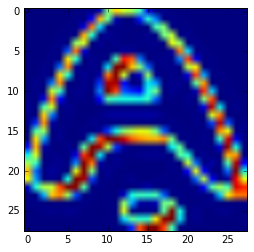

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(testA[5,:,:])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [18]:
#datasets = []

print("Checking training data sizes")
for datafile in train_datasets:
    data = pickle.load( open( datafile, "rb" ))
    print(data.shape)

print("Checking testing data sizes")
for datafile in test_datasets:
    data = pickle.load( open( datafile, "rb" ))
    print(data.shape)

Checking training data sizes
(52909, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
Checking testing data sizes
(1872, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [19]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 20000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (20000, 28, 28) (20000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [20]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [11]:
ord('A')

65

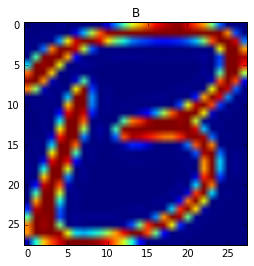

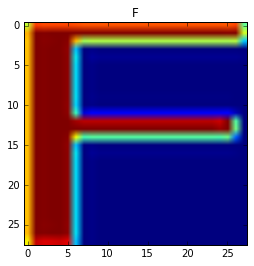

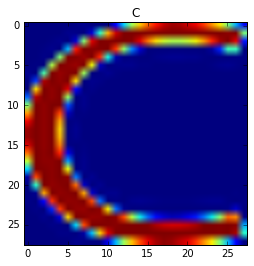

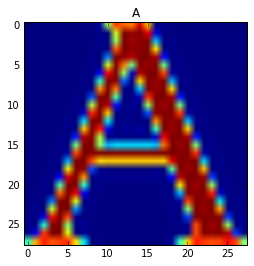

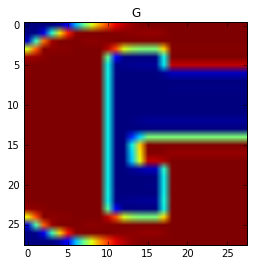

In [21]:
# Show the first five images in the train dataset, should be random letters, true label is plotted as a title
for i in xrange(5):
    plt.figure()
    plt.imshow(train_dataset[i,:,:])
    plt.title(chr(train_labels[i]+ord('A')))

Finally, let's save the data for later reuse:

In [22]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [23]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 125600437


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [11]:
def label_to_letter(i):
    return chr(i+ord('A'))

In [30]:
#load pickle file
pickle_file = 'notMNIST.pickle'
data = pickle.load( open( pickle_file, "rb" ))

In [31]:
train_dataset = data['train_dataset']
train_labels = data['train_labels']
test_dataset = data['test_dataset']
test_labels = data['test_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']
data = None

In [5]:
def image_dist(X,Y):
    '''calculates the Euclidean distance between two vectors'''
    return np.linalg.norm(X-Y)

image_dist(train_dataset[1,:,:],train_dataset[5,:,:])

19.423912

---
Check for Overlaps First
-----
---

There's ambiguity in how the problem 5 question is formulated. Overlapping sample is not explicitly defined. Overlapping can be referred to the training labels, or the images themselves.

In this case, I think the useful (albeit more difficult) intepretation is the overlap between the images themselves.

Check for duplicates between training, testing
---

In [6]:
train_dataset.shape

(20000, 28, 28)

In [7]:
def calc_overlap(dataset1,dataset2):
    '''Calculates the number of overlapping samples between two datasets.
Overlapping samples is determined based on the image_dist(X,Y) function.
Images of different labels shouldnt overlap but we'll do it anyway to keep the code simple '''
    n = dataset1.shape[0]
    m = dataset2.shape[0]
    D = np.ndarray((n,m),dtype=np.float32)
    D.fill(np.nan) #nan

    for j in np.arange(n):
        for k in np.arange(m):
            D[j,k] = image_dist(dataset1[j],dataset2[k])
    return D

D = calc_overlap(train_dataset[:300],test_dataset[:50])

threshold = 9
percent_overlap = (np.sum(D.flatten() < threshold )*1.0)/len(D.flatten()) * 100
print("Percent overlap for the testing case is {0}%".format(percent_overlap))

Percent overlap for the testing case is 0.42%


To apply this calculate_overlap step to the rest of the dataset. We iterate it over all 10 letters using a threshold of 9 for the distance measure.

In [8]:
def calc_overlap_everyletter(dataset1,dataset2,labelset1,labelset2,threshold = 9):
    '''invokes calc_overlap separately for every letter'''
    percent_overlap = []
    
    for letter in np.arange(10):
        filt_1 = (labelset1 == letter)
        filt_2 = (labelset2 == letter)
        D = calc_overlap(dataset1[filt_1],dataset2[filt_2])        
        percent_overlap.append((np.sum(D.flatten() < threshold )*1.0)/len(D.flatten()) * 100)

    return np.array(percent_overlap)


percent_overlap = calc_overlap_everyletter(train_dataset,test_dataset,train_labels,test_labels)

The percent overlap is summarized into a list and displayed below

In [9]:
percent_overlap

array([ 3.62475,  2.9806 ,  6.33925,  3.7333 ,  2.22195,  3.24535,
        2.75655,  3.91875,  9.0726 ,  3.17595])

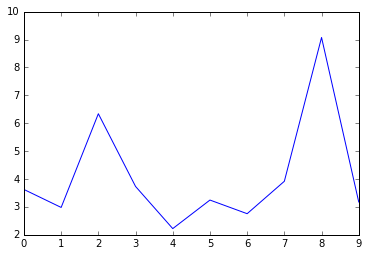

In [10]:
plt.plot(percent_overlap)

In [32]:
percent_overlap_train_validation = calc_overlap_everyletter(train_dataset,valid_dataset,train_labels,valid_labels)

In [35]:
percent_overlap_train_validation

array([ 3.0972 ,  2.31435,  5.6499 ,  3.1113 ,  1.97305,  2.9273 ,
        2.2276 ,  3.46735,  7.62775,  2.6219 ])

In [33]:
percent_overlap_validation_testing = calc_overlap_everyletter(test_dataset,valid_dataset,test_labels,valid_labels)

In [34]:
percent_overlap_validation_testing

array([ 3.7908,  2.9197,  6.527 ,  3.6287,  2.2415,  3.4442,  2.5985,
        4.0503,  8.9523,  3.0867])

In [12]:
label_to_letter(8)

'I'

I has the highest number of overlaps at 9%

---
Check for Duplicates within Dataset
-----
---

In [13]:
def indices(a, func):
    '''Implements MATLAB find( (conditional filter array)) for numpy 1D arrays'''
    return [i for (i, val) in enumerate(a) if func(val)]


def check_letter_for_duplicates(train_dataset,train_labels,i):
    '''returns the indices of letter in dataset and also the cost matrix'''
    inds = indices(train_labels, lambda x: x == i)
    n = len(inds)
    D = np.ndarray((len(inds),len(inds)),dtype=np.float32)
    D.fill(np.nan) #nan
    
    # upper triangular since the matrix is symmetric and we do not need the diagonal
    # saves iterations!
    for j in np.arange(n-1):
        for k in np.arange(j+1,n):
            if j != k:
                D[j,k] = image_dist(train_dataset[inds[j]],train_dataset[inds[k]])
    # D is a upper triangular matrix consisting of costs between i,j pairs
    return inds, D

In [14]:
def find_2D_less_than(D, upper_bound):
    '''returns the row and col that is smaller than the upper_bound, 
similar to [r,c] = find(A < upper_bound)  in MATLAB'''
    D_flat = D.flatten()
    ids_flat = np.array([i for (i,val) in enumerate(D_flat) if ((~np.isnan(val)) and (val < upper_bound))])
    
    row_ids = np.floor(ids_flat / D.shape[0]).astype(np.int)
    col_ids = np.mod(ids_flat, D.shape[0])
    
    return row_ids, col_ids
rows, cols = find_2D_less_than(np.array([[1,2,3],[2,3,4],[4,5,6]]),3)

print(rows)
print(cols)

[0 0 1]
[0 1 0]


(array([  4.20000000e+01,   1.22000000e+02,   7.04000000e+02,
          2.81100000e+03,   8.11500000e+03,   1.82700000e+04,
          3.58270000e+04,   6.58640000e+04,   1.21312000e+05,
          2.02104000e+05,   2.84917000e+05,   3.34050000e+05,
          3.27615000e+05,   2.64709000e+05,   1.73657000e+05,
          1.04567000e+05,   4.42210000e+04,   9.12900000e+03,
          9.17000000e+02,   4.70000000e+01]),
 array([  0.        ,   1.31201239,   2.62402477,   3.93603716,
          5.24804955,   6.56006193,   7.87207432,   9.1840867 ,
         10.49609909,  11.80811148,  13.12012386,  14.43213625,
         15.74414864,  17.05616102,  18.36817341,  19.68018579,
         20.99219818,  22.30421057,  23.61622295,  24.92823534,  26.24024773]),
 <a list of 20 Patch objects>)

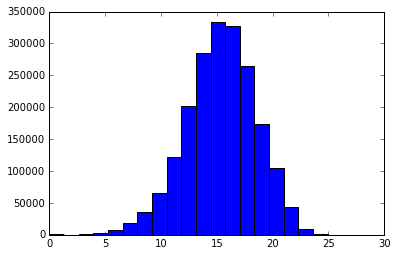

In [15]:
# check this algorithm on letter A first
inds, D = check_letter_for_duplicates(train_dataset,train_labels,0)
flat_D_wo_nan = D.flatten()[~np.isnan(D.flatten())]
plt.hist(flat_D_wo_nan,20)

In [16]:
# set the distance threshold to 3.0
row_idx, col_idx = find_2D_less_than(D, 3.0)
zip(row_idx[:5],col_idx[:5])

[(8, 648), (8, 760), (8, 1513), (12, 615), (12, 1903)]

I noticed that the duplicates are not one-to-one paired. Meaning, maybe image 1 is very similar to 3,4,5,6 and so on. So in that case, we need to perform clustering algorithm to group them together.

---
Perform clustering to group duplicate images together
-------
---

In [17]:
def generate_cluster(row_idx, col_idx):
    '''generate clusters based on mapping vectors of the same dimnension in row and col, helps us find duplicate images'''
    clusters = []
    def find_in_cluster(row,col,clusters):
        for (i,cluster) in enumerate(clusters):
            if (row in cluster) or (col in cluster):
                return i
        return -1

    for (i,row) in enumerate(row_idx):
        col = col_idx[i]
        cluster_idx = find_in_cluster(row,col,clusters);
        #import pdb;pdb.set_trace()
        # if the data already exists in cluster
        if (cluster_idx != -1):
            if row not in clusters[cluster_idx]:
                clusters[cluster_idx].append(row)
            if col not in clusters[cluster_idx]:
                clusters[cluster_idx].append(col)
        else:
            clusters.append([row, col])
    return clusters

clusters = generate_cluster(row_idx,col_idx)

In [18]:
cluster = clusters[0]
print(cluster)
print(cluster[1:])

[8, 648, 760, 1513, 545, 1537, 1602, 577, 1909, 668, 1551, 858, 1112, 1137, 1524, 1601]
[648, 760, 1513, 545, 1537, 1602, 577, 1909, 668, 1551, 858, 1112, 1137, 1524, 1601]


In [19]:
# inds is generated from inds = indices(train_labels, lambda x: x == i)
# clusters is generated from generate_cluster(row_idx,col_idx)
def calculate_removal_inds(clusters,inds):
    '''convert clusters of duplicate images identified from generate_cluster()
into a list of indices (based on the dataset) except the first image.
the list will serve as a filter to remove duplicates.'''
    black_list = []
    for cluster in clusters:
        if len(cluster)>=2:
            black_list = black_list + [inds[i] for i in cluster[1:]] #save one and put the rest on blacklist
    return black_list

black_list = calculate_removal_inds(clusters,inds)
black_list[:5]

[6520, 7673, 15092, 5512, 15397]

In [25]:
print("Identified {0} out of {1} to be duplicates, they will be removed.".format(len(black_list),len(inds)))

Identified 225 out of 2000 to be duplicates, they will be removed.


the following images should be very similar:


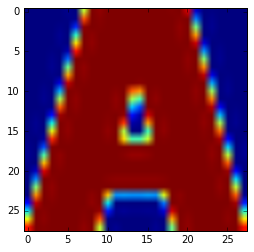

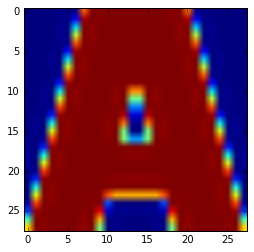

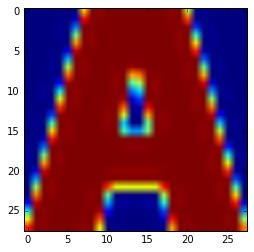

In [22]:
# plotting a few so we actually see that they are identical
j = 7
print("the following images should be very similar:")
for i in np.arange(len(clusters[j])):
    plt.figure()
    plt.imshow(train_dataset[inds[clusters[j][i]]])

In [40]:
# define a funciton to apply it for other letters as well
def get_blacklist():
    blacklist = []
    for digit in np.arange(10):
        inds, D = check_letter_for_duplicates(train_dataset,train_labels,digit)
        row_idx, col_idx = find_2D_less_than(D, 3.0)
        clusters = generate_cluster(row_idx,col_idx)
        blk_i = calculate_removal_inds(clusters,inds)
        blacklist = blacklist + blk_i
        print("Letter {2}: identified {0} out of {1} to be duplicates, they will be removed." \
              .format(len(blk_i),len(inds),label_to_letter(digit)))
    return blacklist

blacklist = get_blacklist()

Letter A: identified 225 out of 2000 to be duplicates, they will be removed.
Letter B: identified 225 out of 2000 to be duplicates, they will be removed.
Letter C: identified 225 out of 2000 to be duplicates, they will be removed.
Letter D: identified 225 out of 2000 to be duplicates, they will be removed.
Letter E: identified 225 out of 2000 to be duplicates, they will be removed.
Letter F: identified 225 out of 2000 to be duplicates, they will be removed.
Letter G: identified 225 out of 2000 to be duplicates, they will be removed.
Letter H: identified 225 out of 2000 to be duplicates, they will be removed.
Letter I: identified 225 out of 2000 to be duplicates, they will be removed.
Letter J: identified 225 out of 2000 to be duplicates, they will be removed.


In [41]:
len(blacklist)

3709

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

LogisticRegression score: 0.596900
LogisticRegression score: 0.711900
LogisticRegression score: 0.837800
LogisticRegression score: 0.854900
LogisticRegression score: 0.871100


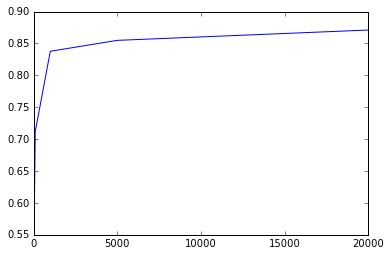

In [71]:
# define the number of training samples
regression_score = []
for n_train in [50,100,1000,5000,20000]:
    X = train_dataset[:n_train]
    y = train_labels[:n_train]

    # flatten the image into a row
    flattenX = lambda X: np.reshape(X,(X.shape[0],X.shape[1]*X.shape[2]))

    logistic = LogisticRegression()
    score = logistic.fit(flattenX(X), y).score(flattenX(test_dataset), test_labels)
    regression_score.append(score)
    print('LogisticRegression score: %f' % score)




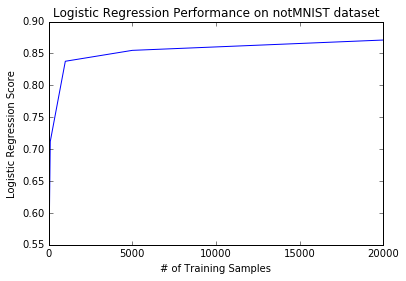

In [74]:
plt.plot([50,100, 1000, 5000, 20000],regression_score)
plt.xlabel('# of Training Samples')
plt.ylabel('Logistic Regression Score')
plt.title('Logistic Regression Performance on notMNIST dataset')